In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import torch
import matplotlib.pyplot as plt
import gip_bnn
import tqdm.auto as tqdm

torch.set_default_dtype(torch.float64)

In [94]:
plt.style.use("ggplot")


### Dataset stuff here:

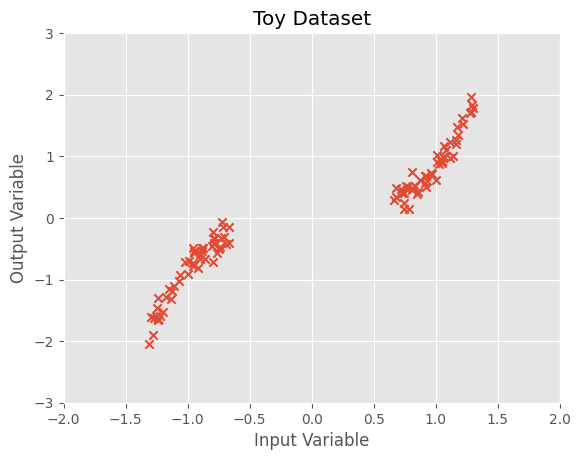

In [95]:
noise_std = torch.tensor(4.0)
dataset_size = 100

x_neg, x_pos = torch.zeros(dataset_size // 2), torch.zeros(dataset_size // 2)
x_neg, x_pos = x_neg.uniform_(-4, -2), x_pos.uniform_(2, 4)
x = torch.cat((x_neg, x_pos))

y = x**3 + noise_std * torch.normal(
    torch.zeros(dataset_size), torch.ones(dataset_size)
)

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

plt.scatter(x, y, marker="x")
plt.title("Toy Dataset")
plt.xlabel("Input Variable")
plt.ylabel("Output Variable")
plt.xlim(-2, 2)
plt.ylim(-3, 3)
plt.show()


### Do some experiments

In [120]:
num_induce = 10
inducing_points = x[torch.randperm(dataset_size)[:num_induce]].unsqueeze(1)

gip_model = gip_bnn.GINetwork(
    1,
    [20, 20],
    1,
    inducing_points,
    nonlinearity=torch.nn.ReLU(),
    trainable_noise=True,
)
print(gip_model)

opt = torch.optim.Adam(gip_model.parameters(), lr=1e-2)


GINetwork(
  (nonlinearity): ReLU()
  (network): ModuleList(
    (0): GILayer(
      (nonlinearity): ReLU()
    )
    (1): GILayer(
      (nonlinearity): ReLU()
    )
    (2): GILayer(
      (nonlinearity): ReLU()
    )
  )
)


In [121]:
loss_evo = []
ll_evo = []
kl_evo = []

epoch_iter = tqdm.tqdm(range(1, 2000), "Epoch")
for epoch in epoch_iter:  # epochs
    opt.zero_grad()

    loss, ll, kl, noise = gip_model.elbo_loss(
        x.unsqueeze(1), y.unsqueeze(1), num_samples=1
    )
    loss_evo.append(loss.item())
    ll_evo.append(ll.item())
    kl_evo.append(kl.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss, "ll": ll, "kl": kl})


Epoch: 100%|██████████| 1999/1999 [00:33<00:00, 59.34it/s, loss=tensor(186.9447, grad_fn=<NegBackward0>), ll=tensor(-48.6983, grad_fn=<MeanBackward0>), kl=tensor(138.2464, grad_fn=<MeanBackward0>)] 


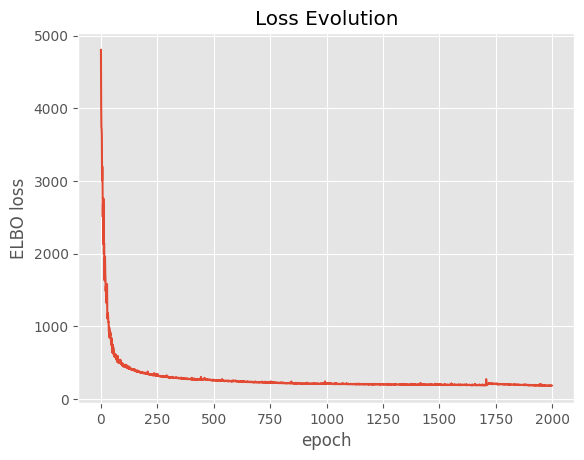

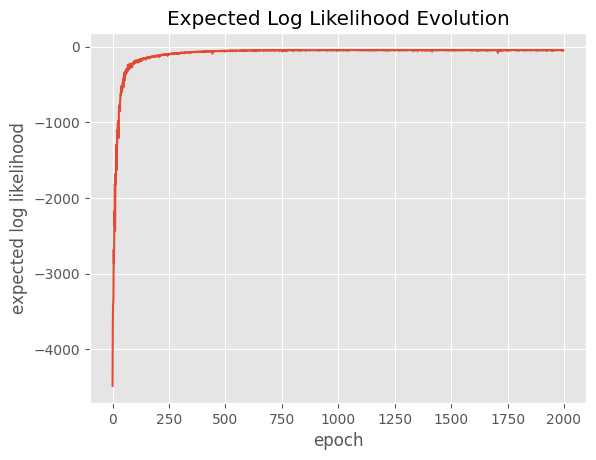

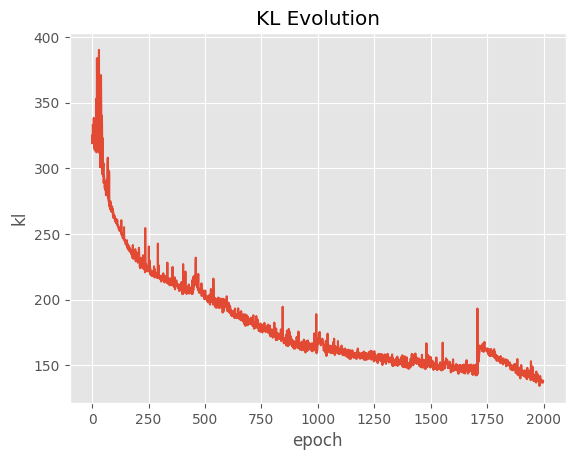

In [122]:
plt.plot(loss_evo)
plt.ylabel("ELBO loss")
plt.xlabel("epoch")
plt.title("Loss Evolution")
plt.show()

plt.plot(ll_evo)
plt.ylabel("expected log likelihood")
plt.xlabel("epoch")
plt.title("Expected Log Likelihood Evolution")
plt.show()

plt.plot(kl_evo)
plt.ylabel("kl")
plt.xlabel("epoch")
plt.title("KL Evolution")
plt.show()


In [123]:
xs = torch.linspace(-2, 2, 100).unsqueeze(1)
prediction_samps = gip_model(xs, num_samples=100)[0].squeeze(-1).T


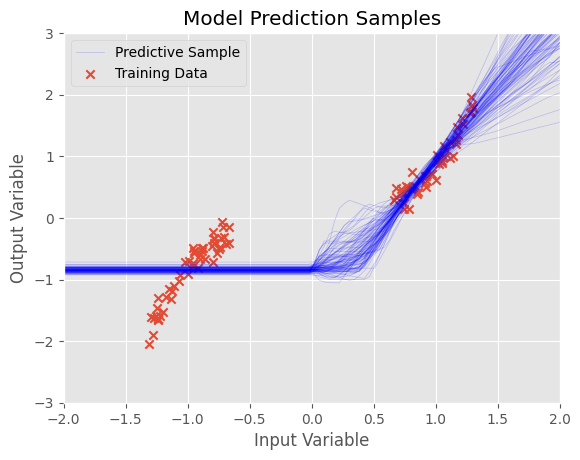

In [124]:
plt.plot(
    xs.detach().numpy(),
    prediction_samps.detach().numpy()[:, :-1],
    color="blue",
    linewidth=0.5,
    alpha=0.2,
)
plt.plot(
    xs.detach().numpy(),
    prediction_samps.detach().numpy()[:, -1],
    color="blue",
    linewidth=0.5,
    alpha=0.2,
    label="Predictive Sample",
)
plt.title("Model Prediction Samples")
plt.xlabel("Input Variable")
plt.ylabel("Output Variable")
plt.scatter(x, y, marker="x", label="Training Data")
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-3, 3)
plt.show()


In [125]:
print(gip_model.noise)

tensor(0.3918, grad_fn=<ExpBackward0>)
